# LOGISTIC REGRESSION

## Import Libraries 

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings

## Import

I'll import the wrangle function and prepare and clean the data from the data exploration notebook.

In [2]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath)
    
    # Rename columns for better clarity and to facilitate analysis
    df.rename(columns={'Age in 5-year groups': 'age',
                       'Type of place of residence': 'residence',
                       'Highest educational level': 'educational_level',
                       'Wealth index combined': 'wealth_index',
                       'Births in last five years': 'births_5_years',
                       'Age of respondent at 1st birth': 'respondent_1st_birth',
                       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                       'Anemia level': 'anemia_level_target',
                       'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_net_owners',
                       'Smokes cigarettes': 'smokers',
                       'Current marital status': 'marital_status',
                       'Currently residing with husband/partner': 'partner_residence',
                       'When child put to breast': 'child_put_breast',
                       'Had fever in last two weeks': 'fever_two_weeks',
                       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                       'Anemia level.1': 'anemia_level_1',
                       'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)
    
    # drop collumn with 50% null values .
    df.drop(columns="anemia_level_1" , inplace = True)
    
    # List of columns to impute
    columns_to_impute = ['hemoglobin_altitude_smoking','hemoglobin_altitude']

    # Convert relevant columns to numeric before imputing
    numeric_columns = columns_to_impute
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Impute missing values with mean
    for column in columns_to_impute:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
    # drop the column for high cardinality
    df.drop(columns="child_put_breast", inplace=True)  
    
    # Fill NaN values in specified columns with the string "Dont know"
    df['anemia_level_target'] = df['anemia_level_target'].fillna("Dont know") 
    
    #'Anemia level'  mapping
    category_mapping = {'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4}

    # Map the categories to numerical values
    df['anemia_level_target'] = df['anemia_level_target'].map(category_mapping)
    
    
    # define a function
    def replace_nan_with_word(x, word='Staying elsewhere'):
        """
        Replace NaN values in a pandas Series with a specified word.

        Parameters:
        - x: pandas Series
        - word: str, default='Staying elsewhere'
        """
        return x.fillna(word)

    # Apply the function to replace NaN values in the column
    df['partner_residence'] = replace_nan_with_word(df['partner_residence'])

    # Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"
    df['fever_two_weeks'] = df['fever_two_weeks'].fillna("Dont know")
    
    # Fill NaN values in the 'iron_pills' column with the string "Dont know"
    df['iron_pills'] = df['iron_pills'].fillna("Dont know")
    

    return df

In [3]:
df = wrangle("children anemia.csv")
df.head()

,age,residence,educational_level,wealth_index,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_net_owners,smokers,marital_status,partner_residence,fever_two_weeks,hemoglobin_altitude,iron_pills
0,40-44,Urban,Higher,Richest,1,22,114.367235,0,Yes,No,Living with partner,Staying elsewhere,No,101.270183,Yes
1,35-39,Urban,Higher,Richest,1,28,114.367235,0,Yes,No,Married,Living with her,No,101.270183,No
2,25-29,Urban,Higher,Richest,1,26,114.367235,0,No,No,Married,Living with her,No,101.270183,No
3,25-29,Urban,Secondary,Richest,1,25,95.000000,1,Yes,No,Married,Living with her,No,114.000000,No
4,20-24,Urban,Secondary,Richest,1,21,114.367235,0,Yes,No,No longer living together/separated,Staying elsewhere,No,101.270183,No


## Split

I'll Create my feature matrix X and target vector y. My target is "anemia_level_target"

In [4]:
# create feature and target .
target = "anemia_level_target"
X = df.drop(columns=target)
y = df[target]

I'll now use a randomized train-test split to divide my data (X and Y) into training and test sets. 20% of my entire data are in my test set. Next, to ensure reproducibility, I'll set a random state.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27139, 14)
y_train shape: (27139,)
X_test shape: (6785, 14)
y_test shape: (6785,)


## Build Model


## Baseline


### Calculating Accuracy Score


A natural choice for a metric for classification is accuracy. Accuracy is equal to the number of observations you correctly classified over all observations. .Accuracy is an easy metric to both understand and calculate. Mathematically, it is simply
number of **correct observations / number of observations**

In [7]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.61


## Iterate


Now I'll build a pipeline called model that has a LogisticRegression predictor and a OneHotEncoder transformer in it. I'll also set my transformer's use cat names argument to True. Afterward, fit it to the training data.

In [18]:
# Detect categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
threshold = 10
categorical_columns = [col for col in categorical_columns if df[col].nunique() <= threshold]


# Define preprocessing steps
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = SimpleImputer(strategy='mean')

categorical_features = categorical_columns
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Build the model pipeline
model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=1000)
)

# Fit the model to the training data
model.fit(X_train, y_train)


/home/linuxsomto/anaconda3/envs/env_name/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['births_5_years', 'respondent_1st_birth', 'hemoglobin_altitude_smoking',
       'hemoglobin_altitude'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age', 'residence',
                                                   'educational_level',
                                                   'wealth_index',
                                                 

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy}')

Model Accuracy: 0.8212232866617538


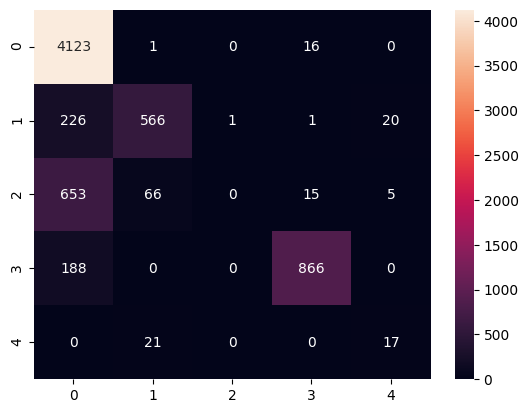

In [24]:
# plot a confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.show()
